In [26]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [7]:
df_rate_books = pd.read_csv(r'/home/ynoureddine/DSTI/DSTI-Project-Machine-Learning-with-Python-Labs/Yosr Solution/DB/df_first_pred.csv')


In [11]:
df_rate_books

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,book_id,country_code,author_mean_rates,genres,year,month,day
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,Scholastic Inc.,1,US,4.46300,"['fantasy, paranormal', 'young-adult', 'fictio...",2006.0,9.0,16.0
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,Scholastic Inc.,2,US,4.46300,"['fantasy, paranormal', 'children', 'fiction',...",2004.0,9.0,1.0
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,2003-11-01,Scholastic,4,US,4.44000,"['fantasy, paranormal', 'young-adult', 'fictio...",2003.0,11.0,1.0
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,2004-05-01,Scholastic Inc.,5,US,4.46300,"['fiction', 'children', 'fantasy, paranormal',...",2004.0,5.0,1.0
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,2004-09-13,Scholastic,8,US,4.46300,"['fantasy, paranormal', 'young-adult', 'fictio...",2004.0,9.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9284,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,20,2004-12-21,Da Capo Press,45631,US,4.07112,"['fiction', 'non-fiction', 'history, historica...",2004.0,12.0,21.0
9285,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,1988-12-01,Penguin Books,45633,US,4.08000,"['fiction', 'fantasy, paranormal']",1988.0,12.0,1.0
9286,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,1993-08-01,Penguin Books,45634,US,4.08000,"['fiction', 'history, historical fiction, biog...",1993.0,8.0,1.0
9287,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,2007-02-27,Ecco,45639,US,4.08000,"['non-fiction', 'history, historical fiction, ...",2007.0,2.0,27.0


In [9]:
df_rate_books.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher', 'book_id', 'country_code',
       'author_mean_rates', 'genres', 'year', 'month', 'day'],
      dtype='object')

In [10]:
df_rate_books.isnull().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
  num_pages           0
ratings_count         0
text_reviews_count    0
publication_date      1
publisher             0
book_id               0
country_code          0
author_mean_rates     0
genres                0
year                  1
month                 1
day                   1
dtype: int64

In [12]:
df_rate_books['genres'].nunique()

1620

In [13]:

# Calculate the frequency of each genre
genre_frequency = df_rate_books['genres'].value_counts(normalize=True)




In [14]:
genre_frequency

['non-fiction', 'history, historical fiction, biography']                                                                                             0.048767
['non-fiction']                                                                                                                                       0.038217
['fiction', 'history, historical fiction, biography']                                                                                                 0.034665
['mystery, thriller, crime', 'fiction']                                                                                                               0.032296
['non-fiction', 'history, historical fiction, biography', 'fiction']                                                                                  0.030251
                                                                                                                                                        ...   
['fantasy, paranormal', 'fiction', 'non-fictio

In [15]:
# Map the frequency values to the 'genres' column
df_rate_books['genres_frequency_encoded'] = df_rate_books['genres'].map(genre_frequency)

In [17]:
df_rate_books.corr()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count,book_id,author_mean_rates,year,month,day,genres_frequency_encoded
bookID,1.000000,-0.037199,0.027853,-0.030443,-0.080473,-0.084322,1.000000,-0.017833,0.024149,-0.006462,-0.012394,-0.010749
average_rating,-0.037199,1.000000,0.035521,0.190740,0.046933,0.038394,-0.037199,0.663158,-0.061234,0.028818,-0.004724,-0.004454
isbn13,0.027853,0.035521,1.000000,-0.036546,-0.041326,-0.049855,0.027853,0.042848,0.101092,-0.007668,-0.062226,-0.029446
num_pages,-0.030443,0.190740,-0.036546,1.000000,0.031742,0.033167,-0.030443,0.047018,-0.029764,0.026626,0.031921,0.070856
ratings_count,-0.080473,0.046933,-0.041326,0.031742,1.000000,0.865313,-0.080473,0.039856,0.044960,-0.018687,-0.004040,-0.061045
text_reviews_count,-0.084322,0.038394,-0.049855,0.033167,0.865313,1.000000,-0.084322,0.030346,0.068782,-0.029289,0.009064,-0.066582
book_id,1.000000,-0.037199,0.027853,-0.030443,-0.080473,-0.084322,1.000000,-0.017833,0.024149,-0.006462,-0.012394,-0.010749
author_mean_rates,-0.017833,0.663158,0.042848,0.047018,0.039856,0.030346,-0.017833,1.000000,-0.030610,0.039055,-0.007205,-0.035719
year,0.024149,-0.061234,0.101092,-0.029764,0.044960,0.068782,0.024149,-0.030610,1.000000,0.018740,0.057219,-0.043709
month,-0.006462,0.028818,-0.007668,0.026626,-0.018687,-0.029289,-0.006462,0.039055,0.018740,1.000000,0.040433,0.019507


In [31]:
df_rate_books.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher', 'book_id', 'country_code',
       'author_mean_rates', 'genres', 'year', 'month', 'day',
       'genres_frequency_encoded', 'title_word_count', 'authors_name_count',
       'author_mean_rates_rating'],
      dtype='object')

<h3> Count words in titles </h3>

In [19]:
df_rate_books['title_word_count'] = df_rate_books['title'].apply(lambda x: len(str(x).split()))


<h3> Count authors </h3>

In [20]:
df_rate_books['authors_name_count'] = df_rate_books['authors'].apply(lambda x: len(str(x).split(',')))


<h3> Creating interaction features can capture relationships between different columns and potentially improve the predictive power of our model.</h3>
<h4> Interaction Feature: 'author_mean_rates' and 'average_rating'</h4>

In [22]:
df_rate_books['author_mean_rates_rating'] = df_rate_books['author_mean_rates'] * df_rate_books['average_rating']


<h4> 'num_pages' column will be divided into bins representing different ranges of page counts (0-100, 101-200, etc.). The resulting 'num_pages_bucket' column contains the corresponding bin labels for each book.</h4>

In [33]:
# Define the bin edges
bin_edges = [0, 100, 200, 300, 400, 500, float('inf')]  

# Create labels for each bin
bin_labels = ['0-100', '101-200', '201-300', '301-400', '401-500', '500+']

In [34]:
# Bucketize the 'num_pages' column
df_rate_books['num_pages_bucket'] = pd.cut(df_rate_books['  num_pages'], bins=bin_edges, labels=bin_labels, include_lowest=True)

In [43]:
df_rate_books['country_code'] = df_rate_books['country_code'].astype('category')


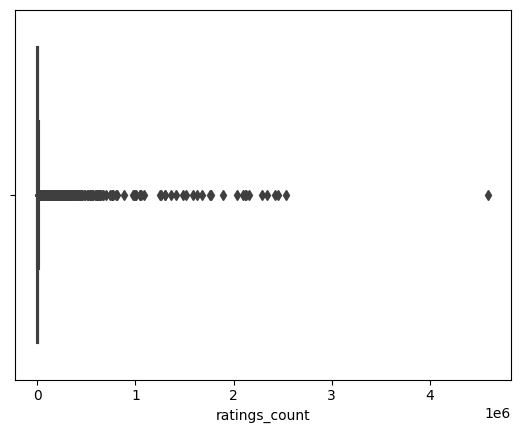

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example for 'ratings_count'
sns.boxplot(x=df_rate_books['ratings_count'])
plt.show()


In [45]:
X = df_rate_books.drop(columns=['average_rating','bookID', 'title', 'authors',
'publication_date','publisher', 'book_id','genres', 'isbn', 'isbn13',
       'language_code'], axis=1) 
y = df_rate_books['average_rating']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [47]:
# Convert the data into LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [48]:
# Set parameters for the LightGBM model
params = {
    'objective': 'regression', 
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'iteration':1000,
    'early_stopping_rounds': 10  # Set early stopping rounds here
}


In [49]:
# Train the model
num_boost_round = 1000  # we can set this to a large number
lgb_model = lgb.train(params, train_data, num_boost_round=num_boost_round,valid_sets=[test_data])

[LightGBM] [Warning] Unknown parameter: iteration
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: iteration
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Unknown parameter: iteration
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[1]	valid_0's rmse: 0.248853
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 0.225727
[3]	valid_0's rmse: 0.206849
[4]	valid_0's rmse: 0.188109
[5]	valid_0's rmse: 0.170968
[6]	valid_0's rmse: 0.155838
[7]	valid_0's rmse: 0.142323
[8]	valid_0's rmse: 0.129794
[9]	valid_0's rmse: 0.118666
[10]	valid_0's rmse: 0.108466
[11]	valid_0's rmse: 0.101022
[12]	valid_0's rmse: 0.0927258
[13]	valid_0's rmse: 0.0852825
[14]	valid_0's rmse: 0.0784269
[15]	valid_0's rmse: 0.0724594
[16]	valid_0's rmse

/home/ynoureddine/.local/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/ynoureddine/.local/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[79]	valid_0's rmse: 0.0190533
[80]	valid_0's rmse: 0.0190825
[81]	valid_0's rmse: 0.0190883
[82]	valid_0's rmse: 0.019076
[83]	valid_0's rmse: 0.0191401
[84]	valid_0's rmse: 0.019094
[85]	valid_0's rmse: 0.0190524
[86]	valid_0's rmse: 0.0189832
[87]	valid_0's rmse: 0.018876
[88]	valid_0's rmse: 0.0188656
[89]	valid_0's rmse: 0.018786
[90]	valid_0's rmse: 0.0187173
[91]	valid_0's rmse: 0.0186475
[92]	valid_0's rmse: 0.0185998
[93]	valid_0's rmse: 0.0185532
[94]	valid_0's rmse: 0.0185061
[95]	valid_0's rmse: 0.0184677
[96]	valid_0's rmse: 0.0184015
[97]	valid_0's rmse: 0.0184009
[98]	valid_0's rmse: 0.0183734
[99]	valid_0's rmse: 0.0183284
[100]	valid_0's rmse: 0.0183051
[101]	valid_0's rmse: 0.0182709
[102]	valid_0's rmse: 0.0182105
[103]	valid_0's rmse: 0.0181686
[104]	valid_0's rmse: 0.0181242
[105]	valid_0's rmse: 0.0180878
[106]	valid_0's rmse: 0.0180694
[107]	valid_0's rmse: 0.0180873
[108]	valid_0's rmse: 0.0180254
[109]	valid_0's rmse: 0.0180361
[110]	valid_0's rmse: 0.0180573
[

In [50]:
y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)


In [51]:
rmse = mean_squared_error(y_test, y_pred, squared=False) 
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.0175433547329944


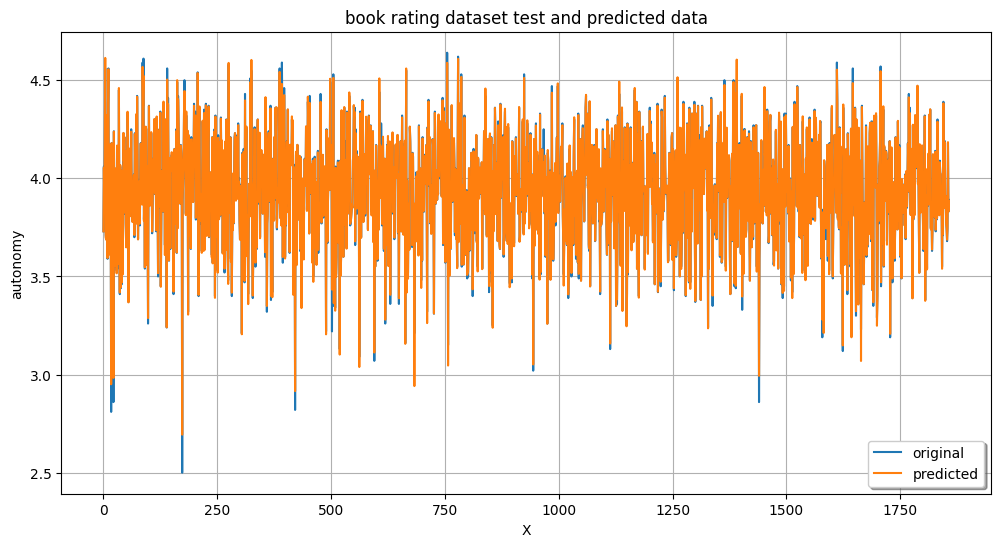

In [52]:
import matplotlib.pyplot as plt
# visualizing in a plot
x_ax = range(len(y_test))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("book rating dataset test and predicted data")
plt.xlabel('X')
plt.ylabel('autonomy')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

 The decrease in RMSE from 0.19 to 0.017 is a positive outcome, indicating that our regression model is performing better in terms of predicting book ratings. It suggests increased accuracy and reduced prediction errors, leading to a more reliable model that's what we can see in the plot.